In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
bus = pd.read_csv('~/Downloads/arrival_times.csv')
bus = bus.dropna(axis=0, how='any')

# combine date and time into a single timestamp
bus['scheduled'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['SCH_STOP_TM'])
bus['actual'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (bus['actual'] - bus['scheduled']) / hour
bus.loc[diff_hrs > 20, 'actual'] -= 24 * hour
bus.loc[diff_hrs < -20, 'actual'] += 24 * hour
bus['minutes_late'] = (bus['actual'] - bus['scheduled']) / minute

bus['route'] = bus['RTE'].replace({673: 'C', 674: 'D', 675: 'E'})
bus['direction'] = bus['DIR'].replace({'N': 'northbound', 'S': 'southbound'})

bus = bus[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

In [3]:
bus_c_n = bus[(bus['route'] == 'C') &
                 (bus['direction'] == 'northbound')].copy()

bus_c_n = bus_c_n.sort_values('scheduled')

minute = np.timedelta64(1, 'm')
bus_c_n['sched_inter'] = bus_c_n['scheduled'].diff() / minute

# Modeling Wait Times

We are interested in modeling the experience a bus rider has at a bus stop waiting for the bus to arrive. We could develop a complex model that involves the intervals between scheduled arrivals, the bus line, and the bus direction. But we will take the simpler approach of narrowing our focus to one line, one direction, and one interval length. We will examine the northbound C line stops that are scheduled for 12 minutes after the previous bus. Both approaches are legitimate. But the first is more complex and this sort of modeling is covered in Chapter 15. 

In the previous section we pared the data down to the northbound C line stops, and now we make the additional restriction that the scheduled arrival time is 12 minutes after the previous bus' scheduled time.

In [4]:
bus_c_n_12 = bus_c_n[bus_c_n['sched_inter'] == 12].copy()

So far, we have been examining the distribution of the number of minutes the bus is late. We can create another histogram of this delay for the subset of data that we are analyzing.

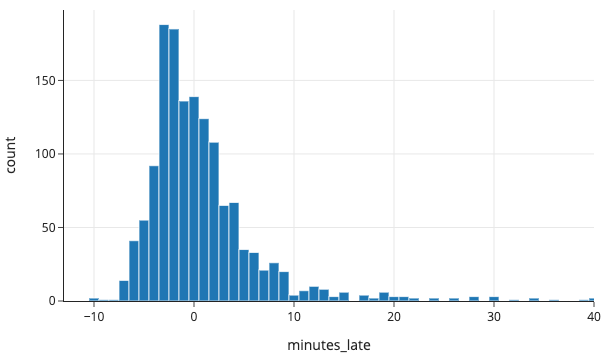

In [5]:
fig = px.histogram(bus_c_n_12, x='minutes_late', 
                   nbins=120, width=350, height=250)

fig.update_xaxes(range=[-13, 40])

fig.show()

However, summarizing how late these buses are does not address the experience of the person waiting for the bus. This is an example of size-biased sampling. A classic example is the difference between sampling children and asking them how big their family is (not including parents) and sampling families and asking how many children are in the family. Families with more children will be over represented in the first approach and the average family size will be larger. The bias enters because the larger families have a greater chance of being selected. However, the first approach is how the family size is experienced by the average child.

Something similar is happening here with the experience of the passengers. When people arrive at a bus stop at random, they are more likely to arrive in a time interval where the bus is delayed because it is a longer interval than the planned one. This means that to answer the question of what do the people experience when waiting for a bus, we need to do more than summarize how late the bus is.

We can design our own data collection process and simulated it with an urn model, like the ones in Chapter 3.  To do this, we set up a hypothetical string of bus arrivals that are 12 minutes apart. We have as many as are in our observed data. 

In [6]:
sched_stack = 12 * np.arange(bus_c_n_12.shape[0])
sched_stack

array([    0,    12,    24, ..., 17172, 17184, 17196])

Then, for each scheduled arrival, we create the actual arrival time from the observed lateness of the real buses. We sort these arrival times because when a bus is really late, another may well come along before it for someone to take.

In [7]:
act_stack = sched_stack + bus_c_n_12['minutes_late'].to_numpy()
act_stack.sort()
act_stack

array([    1.35,     9.93,    26.18, ..., 17166.28, 17184.8 , 17193.4 ])

Now, what we want is to simulate the arrival of people at random throughout the two-month period. We can use an urn model to do this, where we put a marble in the urn with a time on it that's runs from time 0 to the last possible bus arrival. These times can be 1 second apart, or in our case it was simpler to make the 1/100 of a minute apart.  

In [8]:
poss_arrival_times = np.arange(100*act_stack.max())
poss_arrival_times

array([      0.,       1.,       2., ..., 1719338., 1719339., 1719340.])

Now, we're ready to simulate draws from the urn of times to show up at the bus stop. We can draw 100,000 times from the urn, replacing the marble between draws.

In [9]:
sim_arrival_times = np.random.choice(poss_arrival_times, 
                                     size = 100000, replace=True)/100
sim_arrival_times.sort()
sim_arrival_times

array([    0.41,     0.56,     1.61, ..., 17192.91, 17193.25, 17193.26])

To find out how long each individual waits, we look for the actual arrival that is immediately to its right, in other words, the first bus arrival after the individual gets to the bus stop. The difference between these two times is how long they wait. 

In [10]:
i = np.searchsorted(act_stack, sim_arrival_times, side='right')
sim_wait_times = act_stack[i] - sim_arrival_times
sim_wait_times

array([0.94, 0.79, 8.32, ..., 0.49, 0.15, 0.14])

We make a histogram of these waiting times.

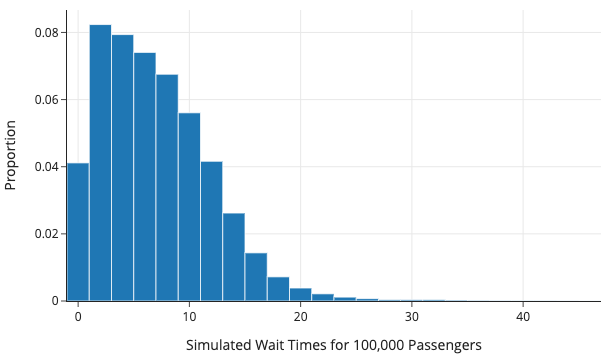

In [11]:
fig = px.histogram(x=sim_wait_times, nbins=40,
                   histnorm='probability density',
                   width=550, height=350)


fig.update_xaxes(title="Simulated Wait Times for 100,000 Passengers")
fig.update_yaxes(title="Proportion")
fig.show()

As we expect, it's a skewed distribution. And when we can model it by a constant (see Chapter4). 

In [12]:
print(f"median wait time: {np.median(sim_wait_times):.2f} minutes")

median wait time: 6.26 minutes


Absolute loss gives us a median wait time of about six and a half minutes.  This doesn't seem to long, but the upper quartile is quite large.

In [13]:
print(f"upper quartile wait time: {np.quantile(sim_wait_times, 0.75):.2f} minutes")

upper quartile wait time: 10.02 minutes


It's undoubtedly memorable when you have to wait more than 10 minutes for a bus that is supposed to arrive every 12 minutes, and this happens one quarter of the time! While our model captures the typical wait time, we also  want to provide an estimate of the variability in the process. 